In [8]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import L1L2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

2.10.0


In [313]:
# find scale parameters in all the data
inputs = pd.read_csv('../../data/Germany/input_data.csv').dropna().set_index('time')['2002-05-01':'2016-12-31']
heads = pd.read_csv('../../data/Germany/heads.csv').dropna().set_index('Date')['2002-05-01':'2016-12-31']

dates = inputs.index
inputs = inputs.values
heads = heads.values

# add heads to input data
inputs = np.append(inputs, heads, axis=1)

# make heads as diff
# heads = np.insert(np.diff(heads, axis=0), 0, 0, axis=0)

T = 14
D = inputs.shape[1]
N = len(inputs) - T
train_ratio = 0.9
Ntrain = int(N * train_ratio)

x_scaler = StandardScaler()
x_scaler.fit(inputs[:Ntrain])
inputs = x_scaler.transform(inputs)

y_scaler = StandardScaler()
y_scaler.fit(heads[:Ntrain])
heads = y_scaler.transform(heads)

In [314]:
# Building sample data
X = np.zeros((N, T, D))
y = np.zeros(N)

for t in range(N):
    X[t, : ,:] = inputs[t:t+T]
    y[t] = heads[t+T, 0]

X_train = X[:Ntrain,:,:]
X_test = X[Ntrain:,:,:]
y_train = y[:Ntrain]
y_test = y[Ntrain:]

print(len(X_train), len(X_test), len(X))

4810 535 5345


In [281]:
# Building model and compile
i = Input(shape=(T,D))
x = LSTM(8, kernel_regularizer=L1L2(l1=0.02, l2=0.02))(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=['cosine_similarity'])

def schedule(epoch, lr):
  if epoch >= 80:
    return 0.005
  elif epoch >= 50:
    return 0.005
  elif epoch >= 30:
    return 0.01  
  return 0.01

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

r = model.fit(
    X_train, y_train,
    batch_size = 256,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[scheduler]
)

Epoch 1/100
19/19 [==============================] - 3s 65ms/step - loss: 1.8392 - cosine_similarity: 0.3709 - val_loss: 0.8435 - val_cosine_similarity: 0.7009 - lr: 0.0100
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6271 - cosine_similarity: 0.8333 - val_loss: 0.3352 - val_cosine_similarity: 0.8617 - lr: 0.0100
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3002 - cosine_similarity: 0.8811 - val_loss: 0.1787 - val_cosine_similarity: 0.8579 - lr: 0.0100
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1660 - cosine_similarity: 0.9031 - val_loss: 0.0964 - val_cosine_similarity: 0.8804 - lr: 0.0100
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1108 - cosine_similarity: 0.9131 - val_loss: 0.0703 - val_cosine_similarity: 0.8916 - lr: 0.0100
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0853 - cosine_similarity: 0.9168 - val_loss: 0.0558 - val_co

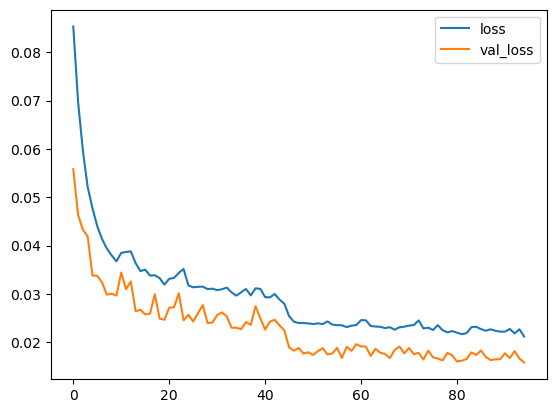

In [282]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'][5:], label='loss')
plt.plot(r.history['val_loss'][5:], label='val_loss')
plt.legend()

17/17 [==============================] - 1s 3ms/step
(535, 1)


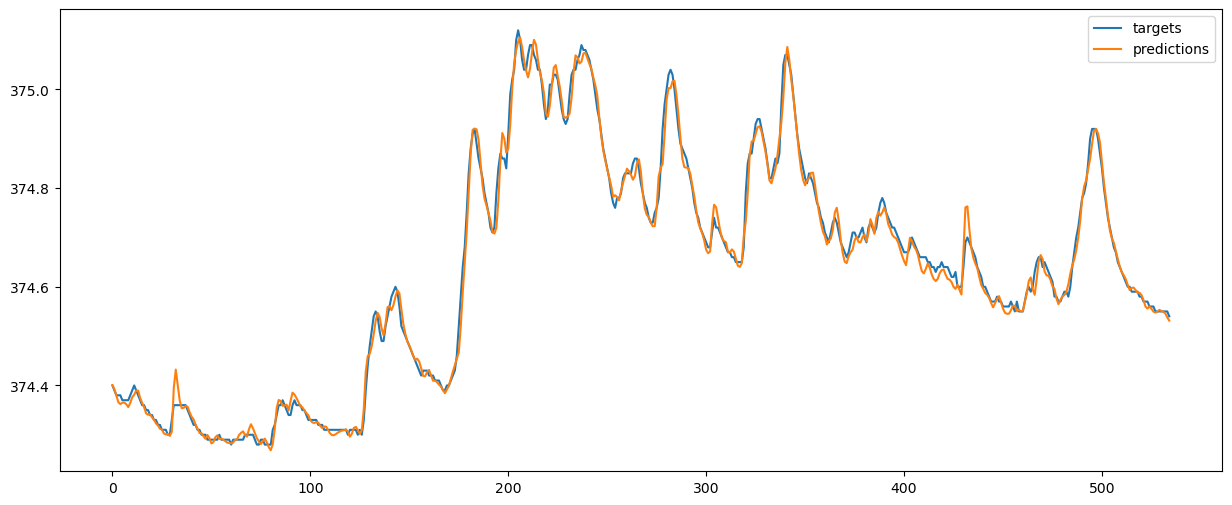

In [283]:
# one-step forcast using true targets
outputs = model.predict(X_test)
print(outputs.shape)
predictions = outputs[:,0]
plt.figure(figsize=(15, 6))
plt.plot(y_scaler.inverse_transform(y_test.reshape((len(y_test),1))), label='targets')
plt.plot(y_scaler.inverse_transform(predictions.reshape((len(y_test),1))), label='predictions')
# plt.plot(y_test, label='targets')
# plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

151/151 [==============================] - 0s 2ms/step
(4810, 1)


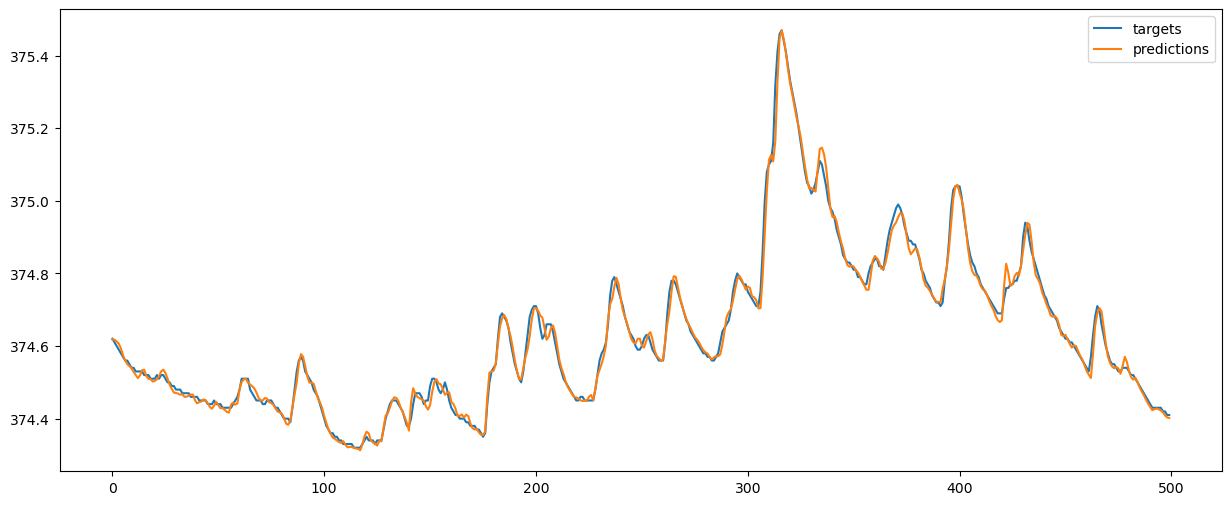

In [284]:
# one-step forcast using true targets
outputs = model.predict(X_train)
print(outputs.shape)
predictions = outputs[:,0]
plt.figure(figsize=(15, 6))
plt.plot(y_scaler.inverse_transform(y_train[-500:].reshape((500,1))), label='targets')
plt.plot(y_scaler.inverse_transform(predictions[-500:].reshape((500,1))), label='predictions')
plt.legend()
plt.show()